In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import LearningRateScheduler

RANDOM_SEED = 42

In [2]:
model_version = "5a"

csv_file = "keypoints\\keypointB_angles_3D.csv"
model_save_path = "model\\customModel\\modelB\\ASLclassifier" + model_version + ".hdf5"
tflite_save_path = "model\\customModel\\modelB\\ASLclassifier" + model_version + ".tflite"

evaluation_folder = "evaluation\\ASL\\"
confmat_path = evaluation_folder + "confusionMatrix" + model_version + ".png"
classrep_path = evaluation_folder + "classificationReport" + model_version + ".csv"
architecture_path = evaluation_folder + "architecture" + model_version + ".png"

In [3]:
NUM_CLASSES = 28
num_identifier_columns = 1
coord_dimensions = 3

In [4]:
# lst = [1] + list(range(num_identifier_columns, (21 * 2) + num_identifier_columns))
lst = list(range(num_identifier_columns, 15))
X_dataset = np.loadtxt(csv_file, delimiter=',', dtype='float32', usecols=lst)

In [5]:
y_dataset = np.loadtxt(csv_file, delimiter=',', dtype='<U8', usecols=0)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED)

In [7]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target data to integers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((14, )),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 25)                375       
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1040      
                                                                 
 dense_2 (Dense)             (None, 28)                1148      
                                                                 
Total params: 2,563
Trainable params: 2,563
Non-trainable params: 0
_________________________________________________________________


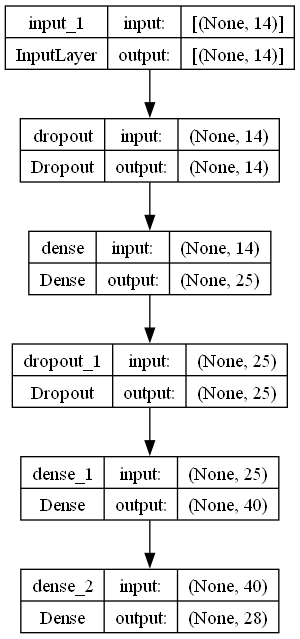

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
# cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=100, verbose=1)

In [12]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 20))

In [13]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']    # , 'Precision', 'Recall'
)

In [14]:
model.fit(
    X_train,
    y_train_encoded,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test_encoded),
    callbacks=[es_callback]    # callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
694/694 [==============================] - 4s 2ms/step - loss: 2.1826 - accuracy: 0.3380 - val_loss: 1.1653 - val_accuracy: 0.6963
Epoch 2/1000
694/694 [==============================] - 1s 2ms/step - loss: 1.5649 - accuracy: 0.5101 - val_loss: 0.9692 - val_accuracy: 0.7860
Epoch 3/1000
694/694 [==============================] - 1s 2ms/step - loss: 1.4130 - accuracy: 0.5587 - val_loss: 0.8666 - val_accuracy: 0.7900
Epoch 4/1000
694/694 [==============================] - 1s 2ms/step - loss: 1.3287 - accuracy: 0.5832 - val_loss: 0.8002 - val_accuracy: 0.8138
Epoch 5/1000
694/694 [==============================] - 1s 2ms/step - loss: 1.2669 - accuracy: 0.6035 - val_loss: 0.7592 - val_accuracy: 0.8201
Epoch 6/1000
694/694 [==============================] - 1s 2ms/step - loss: 1.2193 - accuracy: 0.6191 - val_loss: 0.7376 - val_accuracy: 0.8165
Epoch 7/1000
694/694 [==============================] - 1s 2ms/step - loss: 1.1771 - accuracy: 0.6319 - val_loss: 0.7108 - val_accuracy:

In [15]:
val_loss, val_acc = model.evaluate(X_test, y_test_encoded, batch_size=128)

174/174 [==============================] - 0s 1ms/step - loss: 0.7578 - accuracy: 0.7504


In [16]:
# model = tf.keras.models.load_model(model_save_path)

In [17]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 79ms/step
[2.3649256e-05 7.8967362e-12 7.3617785e-11 8.9418341e-04 2.8109871e-04
 1.0621843e-11 1.0366052e-06 8.4531270e-02 1.0115572e-05 1.7055800e-05
 8.6939508e-01 2.1634780e-07 1.6613421e-05 7.6464485e-06 5.9302488e-06
 6.1257961e-05 2.7644285e-06 1.6206929e-02 2.7295682e-04 3.1287577e-06
 1.3592722e-02 1.3891210e-02 5.5089622e-05 4.9492269e-04 2.0842256e-08
 2.3476798e-04 1.6156007e-07 5.6204591e-08]
10


694/694 [==============================] - 1s 852us/step


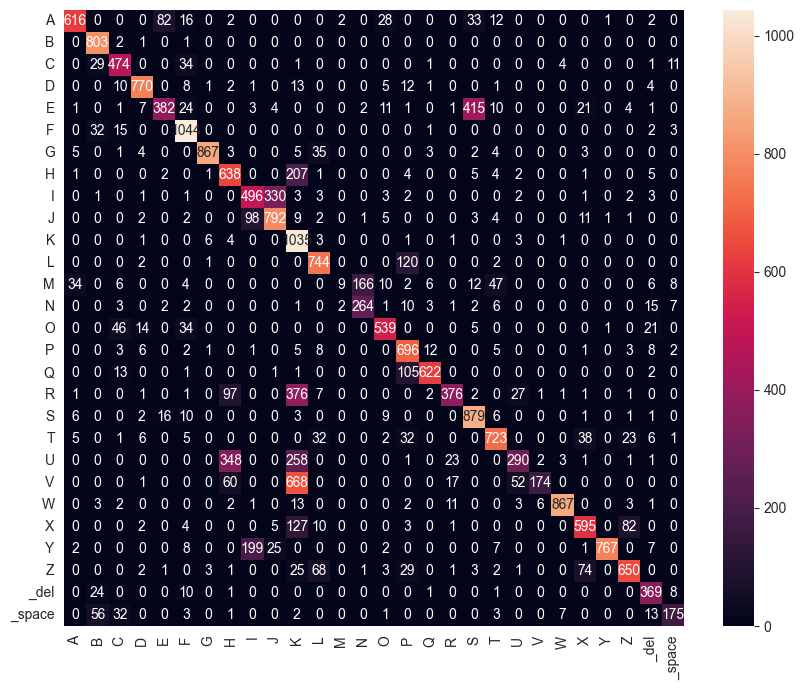

Classification Report
              precision    recall  f1-score   support

           A       0.92      0.78      0.84       794
           B       0.85      1.00      0.92       807
           C       0.78      0.85      0.81       555
           D       0.94      0.93      0.93       828
           E       0.79      0.43      0.56       888
           F       0.86      0.95      0.90      1097
           G       0.99      0.93      0.96       932
           H       0.55      0.73      0.63       871
           I       0.62      0.58      0.60       848
           J       0.68      0.85      0.76       931
           K       0.38      0.98      0.54      1055
           L       0.81      0.86      0.84       869
           M       0.69      0.03      0.06       310
           N       0.61      0.83      0.70       319
           O       0.87      0.82      0.84       660
           P       0.68      0.92      0.79       753
           Q       0.95      0.83      0.89       745
     

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import plot_model

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(10, 8))  # (7, 6)
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

label_encoder.fit(y_train)
y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
y_pred_decoded = label_encoder.inverse_transform(y_pred)


print_confusion_matrix(y_test_decoded, y_pred_decoded)
classrep_dict = classification_report(y_test_decoded, y_pred_decoded, output_dict=True)

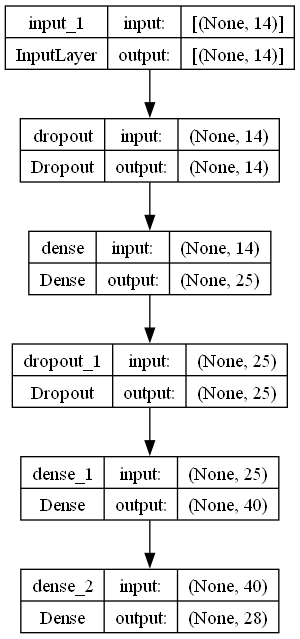

<Figure size 640x480 with 0 Axes>

In [19]:
plt.savefig(confmat_path)

with open(classrep_path, 'w', newline='') as f:
    writer = csv.writer(f)
    # Write the headers
    writer.writerow(["Class", "Precision", "Recall", "F1-Score", "Support"])
    
    # Write the rows
    for key, value in classrep_dict.items():
        if isinstance(value, dict):
            writer.writerow([key, value['precision'], value['recall'], value['f1-score'], value['support']])
        else:
            writer.writerow([key, value])
        
plot_model(model, to_file=architecture_path, show_shapes=True, show_layer_names=True)

# Tensorflow-Lite

In [20]:
model.save(model_save_path, include_optimizer=False)

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ivono\AppData\Local\Temp\tmpe9p4x8pa\assets


INFO:tensorflow:Assets written to: C:\Users\ivono\AppData\Local\Temp\tmpe9p4x8pa\assets


9088

In [22]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [23]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [24]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [25]:
%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1.51 ms


In [26]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.2544315e-05 7.1533873e-12 6.2685593e-11 8.0806023e-04 2.8762160e-04
 1.0056962e-11 1.1077331e-06 8.8238582e-02 1.1147385e-05 1.2903439e-05
 8.6713296e-01 2.1169660e-07 1.6282722e-05 7.1037066e-06 5.6378312e-06
 4.6275447e-05 2.7849997e-06 1.5890265e-02 2.9831679e-04 2.7016965e-06
 1.3145747e-02 1.3217066e-02 6.0089282e-05 5.7272025e-04 1.9741263e-08
 2.1952117e-04 1.7420065e-07 6.4588015e-08]
10
